In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import lightgbm as lgb
import xgboost as xgb

In [4]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.pipeline import make_pipeline, make_union
from sklearn.cluster import DBSCAN

In [5]:
from tpot.builtins import StackingEstimator

In [6]:
from sklearn.cluster import KMeans

In [7]:
filename = "uklon_sample_3_months_dropnan_driver_id.csv"

In [8]:
parse_dates = ['created_at']

In [9]:
df = pd.read_csv(filename, delimiter=",", parse_dates=parse_dates)

/home/temenid/.local/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [10]:
df.head()

,order_id,ride_id,created_at,pickup_lat,pickup_lon,dropoff_lat,dropoff_lon,user_id,driver_id,ride_distance,...,ooExtraCost,ooInitialCost,ooIdleCost,oapAzureMlCost,oapAzureMlCostBid,oapCostProvider,ooSurgeMultiplier,driver_lat,driver_lon,dtTaxiDriver_tdID
0,88314768,764A34A6-5C92-4A0C-90E8-82BDA5A5F9C1,2017-10-31 23:59:59.143,50.448906,30.386448,50.410267,30.412216,420361.0,568114.0,9.10,...,1.0,115.0,0.0,114.0,1.0,AzureML,1.35,50.437012,30.383680,568114.0
1,88314766,299E8328-8BE6-4097-AF81-4834478B4D51,2017-10-31 23:59:58.577,50.446000,30.576200,50.414604,30.384350,722883.0,553135.0,19.74,...,0.0,146.0,0.0,146.0,0.0,AzureML,1.00,50.449512,30.595537,553135.0
2,88314763,4EDC7FB9-5E34-4132-A2B3-B926F81DB439,2017-10-31 23:59:55.050,50.438610,30.459536,50.439339,30.444427,693323.0,568920.0,11.08,...,-7.0,100.0,0.0,107.0,1.0,AzureML,1.09,50.424972,30.458965,568920.0
3,88314762,D0EE9C9A-CFDD-44F8-906D-7C3A7ED65A1C,2017-10-31 23:59:54.420,50.449707,30.515345,50.459896,30.402002,17563.0,527239.0,9.24,...,0.0,88.0,0.0,88.0,0.0,NaN,1.00,50.455327,30.515555,527239.0
4,88314759,18B41EC0-B379-4621-BF7A-DD881D16E038,2017-10-31 23:59:50.053,50.397000,30.632500,50.416607,30.633417,754011.0,531709.0,3.73,...,0.0,55.0,0.0,NaN,NaN,NaN,1.01,NaN,NaN,NaN


In [11]:
df.columns

Index(['order_id', 'ride_id', 'created_at', 'pickup_lat', 'pickup_lon',
       'dropoff_lat', 'dropoff_lon', 'user_id', 'driver_id', 'ride_distance',
       'ooCancelReason', 'ooSuburbanDistance', 'ooCarSearchTime', 'ooCost',
       'ooExtraCost', 'ooInitialCost', 'ooIdleCost', 'oapAzureMlCost',
       'oapAzureMlCostBid', 'oapCostProvider', 'ooSurgeMultiplier',
       'driver_lat', 'driver_lon', 'dtTaxiDriver_tdID'],
      dtype='object')

In [12]:
df.isnull().sum()

order_id                    0
ride_id                     0
created_at                  0
pickup_lat                565
pickup_lon                565
dropoff_lat               780
dropoff_lon               780
user_id                378190
driver_id                   0
ride_distance               0
ooCancelReason              0
ooSuburbanDistance          0
ooCarSearchTime             0
ooCost                      0
ooExtraCost                 0
ooInitialCost               0
ooIdleCost                  0
oapAzureMlCost        1521212
oapAzureMlCostBid     1521212
oapCostProvider       1350984
ooSurgeMultiplier           0
driver_lat             417486
driver_lon             417486
dtTaxiDriver_tdID      417486
dtype: int64

In [13]:
df.shape

(2815393, 24)

In [14]:
df = df.sample(n=1800000)

In [15]:
df.shape

(1800000, 24)

In [16]:
# Remove rows with missing values in column 'driver_id'. The order was not accepted. there was no trip
new_df = df.dropna(subset=['driver_id','pickup_lat','pickup_lon','dropoff_lat','dropoff_lon'],inplace=False)

In [17]:
# leave only uncanceled ride
new_df = new_df.loc[df['ooCancelReason'] == 0]

In [18]:
new_df.shape

(1515835, 24)

In [19]:
# initialy select the following columns
data = new_df[['created_at','ride_distance', 'ooSuburbanDistance', 'ooCarSearchTime', 'ooCost','ooIdleCost','pickup_lat','pickup_lon','dropoff_lat','dropoff_lon','ooSurgeMultiplier']] # ,'ooIdleCost'

In [20]:
data[data['ooIdleCost'] >0].head()

,created_at,ride_distance,ooSuburbanDistance,ooCarSearchTime,ooCost,ooIdleCost,pickup_lat,pickup_lon,dropoff_lat,dropoff_lon,ooSurgeMultiplier
459575,2017-10-18 00:58:42.960,7.24,0,133,96.0,22.0,50.433178,30.603439,50.408382,30.672473,1.0
679533,2017-10-11 10:27:14.010,6.04,0,9,81.0,14.0,50.421380,30.643393,50.434784,30.647507,1.0
347766,2017-10-21 11:12:24.073,16.94,0,10,196.0,16.0,50.415356,30.630711,50.454636,30.448132,1.0
1186361,2017-09-25 17:35:33.860,10.65,0,12,118.0,18.0,50.468285,30.469759,50.508362,30.491032,1.0
96114,2017-10-29 00:12:16.240,2.77,0,13,63.0,14.0,50.402855,30.636692,50.417938,30.625002,1.0


In [21]:
# count the NaN values in a columns
data.isnull().sum()

created_at            0
ride_distance         0
ooSuburbanDistance    0
ooCarSearchTime       0
ooCost                0
ooIdleCost            0
pickup_lat            0
pickup_lon            0
dropoff_lat           0
dropoff_lon           0
ooSurgeMultiplier     0
dtype: int64

In [22]:
data['corrCost'] = data.apply(lambda row: row['ooCost'] - row['ooIdleCost'], axis=1)

/home/temenid/.local/lib/python3.5/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [23]:
# some simple feature engineering with date
# as categorical
data['quarter'] = data['created_at'].dt.quarter.astype(str)
data['month'] = data['created_at'].dt.month.astype(str)
data['day'] = data['created_at'].dt.day.astype(str)
data['dayofweek'] = data['created_at'].dt.dayofweek.astype(str)
data['hour'] = data['created_at'].dt.hour.astype(str)
data['date'] = data['created_at'].dt.strftime('%Y-%m-%d')
data['floor_date'] = data['created_at'].dt.floor('30min').astype(str)
data['floor_15min'] = data['created_at'].dt.floor('15min').astype(str)
data['ceil_15min'] = data['created_at'].dt.ceil('15min').astype(str)

/home/temenid/.local/lib/python3.5/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/temenid/.local/lib/python3.5/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/home/temenid/.local/lib/python3.5/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

In [24]:
# as categorical
data['quarter_int'] = data['created_at'].dt.quarter.astype(int)
data['month_int'] = data['created_at'].dt.month.astype(int)
data['day_int'] = data['created_at'].dt.day.astype(int)
data['dayofweek_int'] = data['created_at'].dt.dayofweek.astype(int)
data['hour_int'] = data['created_at'].dt.hour.astype(int)

/home/temenid/.local/lib/python3.5/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/temenid/.local/lib/python3.5/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [25]:
data.head()

,created_at,ride_distance,ooSuburbanDistance,ooCarSearchTime,ooCost,ooIdleCost,pickup_lat,pickup_lon,dropoff_lat,dropoff_lon,...,hour,date,floor_date,floor_15min,ceil_15min,quarter_int,month_int,day_int,dayofweek_int,hour_int
303601,2017-10-22 20:41:38.547,11.63,0,8,98.0,0.0,50.397804,30.642656,50.461651,30.590183,...,20,2017-10-22,2017-10-22 20:30:00,2017-10-22 20:30:00,2017-10-22 20:45:00,4,10,22,6,20
763531,2017-10-08 18:45:08.420,4.80,0,17,88.0,0.0,50.490400,30.490000,50.514866,30.493179,...,18,2017-10-08,2017-10-08 18:30:00,2017-10-08 18:45:00,2017-10-08 19:00:00,4,10,8,6,18
2228525,2017-08-21 07:26:20.477,25.78,0,2,182.0,0.0,50.503712,30.238102,50.421490,30.523184,...,7,2017-08-21,2017-08-21 07:00:00,2017-08-21 07:15:00,2017-08-21 07:30:00,3,8,21,0,7
357582,2017-10-21 01:38:28.930,12.74,0,13,115.0,0.0,50.459600,30.406500,50.398148,30.323816,...,1,2017-10-21,2017-10-21 01:30:00,2017-10-21 01:30:00,2017-10-21 01:45:00,4,10,21,5,1
1098302,2017-09-28 18:47:00.410,7.75,0,52,100.0,0.0,50.414566,30.519665,50.468460,30.510124,...,18,2017-09-28,2017-09-28 18:30:00,2017-09-28 18:45:00,2017-09-28 19:00:00,3,9,28,3,18


In [26]:
dt = {'date': ['2017-08-24', '2017-10-14'], 
        'isHolidays': [1, 1]}
holidays = pd.DataFrame(dt, columns = ['date', 'isHolidays'])

In [27]:
weather = pd.read_csv('weather_history_2017.csv', delimiter=";", decimal=',')

In [28]:
weather.head()

,floor_date,"Temp,C",Weather,"Wind,km/h",Humidity,"Barometer,mbar"
0,2017-08-01 00:00:00,19,Clear,6,0.83,1020
1,2017-08-01 00:30:00,18,Clear,6,0.94,1021
2,2017-08-01 01:00:00,18,Clear,6,0.88,1021
3,2017-08-01 01:30:00,18,Clear,6,0.88,1021
4,2017-08-01 02:00:00,18,Clear,6,0.88,1021


In [29]:
weather.describe()

,"Temp,C","Wind,km/h",Humidity,"Barometer,mbar"
count,4416.000000,4416.000000,4416.000000,4416.000000
mean,15.276042,12.468976,0.721587,1015.846241
std,7.707456,7.541801,0.187891,8.560472
min,-3.000000,0.000000,0.200000,978.000000
25%,9.000000,6.000000,0.590000,1011.000000
50%,14.000000,13.000000,0.750000,1016.000000
75%,21.000000,17.000000,0.880000,1020.000000
max,34.000000,43.000000,1.000000,1039.000000


In [30]:
data = pd.merge(data, holidays, on='date', how='left')

In [31]:
data = pd.merge(data, weather, on='floor_date', how='left')

In [32]:
data['isHolidays'].fillna(value=0, inplace=True)

In [33]:
data.isnull().sum()

created_at            0
ride_distance         0
ooSuburbanDistance    0
ooCarSearchTime       0
ooCost                0
ooIdleCost            0
pickup_lat            0
pickup_lon            0
dropoff_lat           0
dropoff_lon           0
ooSurgeMultiplier     0
corrCost              0
quarter               0
month                 0
day                   0
dayofweek             0
hour                  0
date                  0
floor_date            0
floor_15min           0
ceil_15min            0
quarter_int           0
month_int             0
day_int               0
dayofweek_int         0
hour_int              0
isHolidays            0
Temp,C                0
Weather               0
Wind,km/h             0
Humidity              0
Barometer,mbar        0
dtype: int64

In [34]:
data.shape

(1515835, 32)

In [35]:
data.head()

,created_at,ride_distance,ooSuburbanDistance,ooCarSearchTime,ooCost,ooIdleCost,pickup_lat,pickup_lon,dropoff_lat,dropoff_lon,...,month_int,day_int,dayofweek_int,hour_int,isHolidays,"Temp,C",Weather,"Wind,km/h",Humidity,"Barometer,mbar"
0,2017-10-22 20:41:38.547,11.63,0,8,98.0,0.0,50.397804,30.642656,50.461651,30.590183,...,10,22,6,20,0.0,1,Clear,6,0.87,1019
1,2017-10-08 18:45:08.420,4.80,0,17,88.0,0.0,50.490400,30.490000,50.514866,30.493179,...,10,8,6,18,0.0,9,Rain,17,0.94,1007
2,2017-08-21 07:26:20.477,25.78,0,2,182.0,0.0,50.503712,30.238102,50.421490,30.523184,...,8,21,0,7,0.0,19,Clear,6,0.68,1014
3,2017-10-21 01:38:28.930,12.74,0,13,115.0,0.0,50.459600,30.406500,50.398148,30.323816,...,10,21,5,1,0.0,9,Clouds,6,0.87,1020
4,2017-09-28 18:47:00.410,7.75,0,52,100.0,0.0,50.414566,30.519665,50.468460,30.510124,...,9,28,3,18,0.0,12,Clear,17,0.44,1037


### Clusterization

In [36]:
pickup_coords = data.loc[:,['pickup_lat','pickup_lon']]
dropoff_coords = data.loc[:,['dropoff_lat','dropoff_lon']]
ride_coords = data.loc[:,['pickup_lat','pickup_lon','dropoff_lat','dropoff_lon']]

In [37]:
num_pickup_clusters = 7
num_dropoff_clusters = 7
num_ride_clusters = 7

In [38]:
pickup_kmeans = KMeans(n_clusters=num_pickup_clusters, random_state=1).fit(pickup_coords)

In [39]:
dropoff_kmeans = KMeans(n_clusters=num_dropoff_clusters, random_state=1).fit(dropoff_coords)

In [40]:
ride_kmeans = KMeans(n_clusters=num_ride_clusters, random_state=1).fit(ride_coords)

In [41]:
id_pickup_label=pickup_kmeans.labels_
id_dropoff_label=dropoff_kmeans.labels_
id_ride_label=ride_kmeans.labels_

In [42]:
id_pickup_label.shape, id_dropoff_label.shape

((1515835,), (1515835,))

In [43]:
data['pickup_cluster'] = id_pickup_label.astype(str)
data['dropoff_cluster'] = id_dropoff_label.astype(str)
data['ride_cluster'] = id_ride_label.astype(str)

In [44]:
data.head()

,created_at,ride_distance,ooSuburbanDistance,ooCarSearchTime,ooCost,ooIdleCost,pickup_lat,pickup_lon,dropoff_lat,dropoff_lon,...,hour_int,isHolidays,"Temp,C",Weather,"Wind,km/h",Humidity,"Barometer,mbar",pickup_cluster,dropoff_cluster,ride_cluster
0,2017-10-22 20:41:38.547,11.63,0,8,98.0,0.0,50.397804,30.642656,50.461651,30.590183,...,20,0.0,1,Clear,6,0.87,1019,1,5,3
1,2017-10-08 18:45:08.420,4.80,0,17,88.0,0.0,50.490400,30.490000,50.514866,30.493179,...,18,0.0,9,Rain,17,0.94,1007,6,6,6
2,2017-08-21 07:26:20.477,25.78,0,2,182.0,0.0,50.503712,30.238102,50.421490,30.523184,...,7,0.0,19,Clear,6,0.68,1014,2,4,5
3,2017-10-21 01:38:28.930,12.74,0,13,115.0,0.0,50.459600,30.406500,50.398148,30.323816,...,1,0.0,9,Clouds,6,0.87,1020,2,0,0
4,2017-09-28 18:47:00.410,7.75,0,52,100.0,0.0,50.414566,30.519665,50.468460,30.510124,...,18,0.0,12,Clear,17,0.44,1037,3,4,6


In [45]:
data.tail()

,created_at,ride_distance,ooSuburbanDistance,ooCarSearchTime,ooCost,ooIdleCost,pickup_lat,pickup_lon,dropoff_lat,dropoff_lon,...,hour_int,isHolidays,"Temp,C",Weather,"Wind,km/h",Humidity,"Barometer,mbar",pickup_cluster,dropoff_cluster,ride_cluster
1515830,2017-09-30 21:27:29.660,8.99,0,7,86.0,0.0,50.449059,30.595373,50.439491,30.520662,...,21,0.0,8,Clouds,9,0.71,1029,4,4,1
1515831,2017-09-19 12:17:59.710,6.54,0,1,73.0,0.0,50.428028,30.508965,50.412930,30.449760,...,12,0.0,18,Clear,6,0.43,1019,3,2,6
1515832,2017-10-09 15:21:59.373,13.50,0,5,132.0,12.0,50.510374,30.416989,50.473743,30.512367,...,15,0.0,11,Clear,24,0.62,1008,6,4,5
1515833,2017-10-27 04:54:05.033,11.46,0,20,100.0,0.0,50.440353,30.489338,50.438126,30.614677,...,4,0.0,8,Clouds,13,0.87,1012,3,1,4
1515834,2017-10-25 07:29:25.717,11.78,0,30,120.0,0.0,50.387523,30.490342,50.467213,30.515562,...,7,0.0,-2,Clouds,9,1.00,1028,0,4,6


In [46]:
data.shape

(1515835, 35)

In [47]:
data.describe()

,ride_distance,ooSuburbanDistance,ooCarSearchTime,ooCost,ooIdleCost,pickup_lat,pickup_lon,dropoff_lat,dropoff_lon,ooSurgeMultiplier,...,quarter_int,month_int,day_int,dayofweek_int,hour_int,isHolidays,"Temp,C","Wind,km/h",Humidity,"Barometer,mbar"
count,1.515835e+06,1515835.0,1.515835e+06,1.515835e+06,1.515835e+06,1.515835e+06,1.515835e+06,1.515835e+06,1.515835e+06,1.515835e+06,...,1.515835e+06,1.515835e+06,1.515835e+06,1.515835e+06,1.515835e+06,1.515835e+06,1.515835e+06,1.515835e+06,1.515835e+06,1.515835e+06
mean,1.104293e+01,0.0,1.907319e+01,1.053271e+02,4.280585e-01,5.044618e+01,3.051368e+01,5.044612e+01,3.051380e+01,1.042990e+00,...,3.360649e+00,9.047561e+00,1.585672e+01,3.011268e+00,1.334015e+01,2.163164e-02,1.544921e+01,1.305027e+01,7.057219e-01,1.015686e+03
std,7.235479e+00,0.0,3.095442e+01,4.991148e+01,3.356269e+00,3.855213e-02,8.297478e-02,4.070110e-02,8.881907e-02,1.355654e-01,...,4.801889e-01,8.194356e-01,8.863910e+00,1.954076e+00,6.565159e+00,1.454776e-01,7.816854e+00,7.766031e+00,1.883889e-01,8.597173e+00
min,1.000000e-02,0.0,-3.528000e+03,3.000000e+01,0.000000e+00,5.008484e+01,2.987967e+01,5.006435e+01,2.988402e+01,1.000000e+00,...,3.000000e+00,8.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-3.000000e+00,0.000000e+00,2.000000e-01,9.780000e+02
25%,5.610000e+00,0.0,5.000000e+00,7.000000e+01,0.000000e+00,5.042288e+01,3.046689e+01,5.042166e+01,3.046437e+01,1.000000e+00,...,3.000000e+00,8.000000e+00,8.000000e+00,1.000000e+00,9.000000e+00,0.000000e+00,9.000000e+00,9.000000e+00,5.700000e-01,1.011000e+03
50%,9.950000e+00,0.0,9.000000e+00,1.000000e+02,0.000000e+00,5.044252e+01,3.051060e+01,5.044227e+01,3.050891e+01,1.000000e+00,...,3.000000e+00,9.000000e+00,1.600000e+01,3.000000e+00,1.400000e+01,0.000000e+00,1.400000e+01,1.300000e+01,7.200000e-01,1.016000e+03
75%,1.450000e+01,0.0,2.300000e+01,1.250000e+02,0.000000e+00,5.046570e+01,3.054613e+01,5.046724e+01,3.055311e+01,1.000000e+00,...,4.000000e+00,1.000000e+01,2.300000e+01,5.000000e+00,1.900000e+01,0.000000e+00,2.100000e+01,1.700000e+01,8.700000e-01,1.020000e+03
max,1.428400e+02,0.0,4.747000e+03,1.634000e+03,2.920000e+02,5.081271e+01,3.098882e+01,5.081271e+01,3.099136e+01,3.500000e+00,...,4.000000e+00,1.000000e+01,3.100000e+01,6.000000e+00,2.300000e+01,1.000000e+00,3.400000e+01,4.300000e+01,1.000000e+00,1.039000e+03


### Demand

In [48]:
def my_agg(x):
    columns = x.columns
    #print(columns[1])
    column_name = columns[1] + "_" + 'demand'
    names = {
        column_name:  x[columns[1]].count(),
    }
    return pd.Series(names, index=[column_name])

In [49]:
#orders = data[['floor_15min', 'created_at','ceil_15min','pickup_cluster']]
pickup_orders = data[['ceil_15min','pickup_cluster']]
dropoff_orders = data[['ceil_15min','dropoff_cluster']]
ride_orders = data[['ceil_15min','ride_cluster']]

In [50]:
pickup_demand = pickup_orders.groupby(['ceil_15min','pickup_cluster'], as_index=False).apply(my_agg).reset_index()
dropoff_demand = dropoff_orders.groupby(['ceil_15min','dropoff_cluster'], as_index=False).apply(my_agg).reset_index()
ride_demand = ride_orders.groupby(['ceil_15min','ride_cluster'], as_index=False).apply(my_agg).reset_index()

In [51]:
pickup_demand.head()

,ceil_15min,pickup_cluster,pickup_cluster_demand
0,2017-08-01 00:15:00,0,21
1,2017-08-01 00:15:00,1,12
2,2017-08-01 00:15:00,2,6
3,2017-08-01 00:15:00,3,67
4,2017-08-01 00:15:00,4,11


In [52]:
dropoff_demand.head()

,ceil_15min,dropoff_cluster,dropoff_cluster_demand
0,2017-08-01 00:15:00,0,16
1,2017-08-01 00:15:00,1,18
2,2017-08-01 00:15:00,2,32
3,2017-08-01 00:15:00,3,4
4,2017-08-01 00:15:00,4,30


In [53]:
ride_demand.head()

,ceil_15min,ride_cluster,ride_cluster_demand
0,2017-08-01 00:15:00,0,23
1,2017-08-01 00:15:00,1,10
2,2017-08-01 00:15:00,2,4
3,2017-08-01 00:15:00,3,11
4,2017-08-01 00:15:00,4,21


In [54]:
# drop ceil_15min from data
data.drop(['ceil_15min'], axis=1,inplace=True)

In [55]:
data = pd.merge(data, pickup_demand, left_on= ['floor_15min', 'pickup_cluster'], right_on=['ceil_15min', 'pickup_cluster'], how='left')
data = pd.merge(data, dropoff_demand, left_on= ['floor_15min', 'dropoff_cluster'], right_on=['ceil_15min', 'dropoff_cluster'], how='left')
data = pd.merge(data, ride_demand, left_on= ['floor_15min', 'ride_cluster'], right_on=['ceil_15min', 'ride_cluster'], how='left')

In [56]:
data.head()

,created_at,ride_distance,ooSuburbanDistance,ooCarSearchTime,ooCost,ooIdleCost,pickup_lat,pickup_lon,dropoff_lat,dropoff_lon,...,"Barometer,mbar",pickup_cluster,dropoff_cluster,ride_cluster,ceil_15min_x,pickup_cluster_demand,ceil_15min_y,dropoff_cluster_demand,ceil_15min,ride_cluster_demand
0,2017-10-22 20:41:38.547,11.63,0,8,98.0,0.0,50.397804,30.642656,50.461651,30.590183,...,1019,1,5,3,2017-10-22 20:30:00,23.0,2017-10-22 20:30:00,18.0,2017-10-22 20:30:00,21.0
1,2017-10-08 18:45:08.420,4.80,0,17,88.0,0.0,50.490400,30.490000,50.514866,30.493179,...,1007,6,6,6,2017-10-08 18:45:00,41.0,2017-10-08 18:45:00,41.0,2017-10-08 18:45:00,102.0
2,2017-08-21 07:26:20.477,25.78,0,2,182.0,0.0,50.503712,30.238102,50.421490,30.523184,...,1014,2,4,5,2017-08-21 07:15:00,11.0,2017-08-21 07:15:00,46.0,2017-08-21 07:15:00,20.0
3,2017-10-21 01:38:28.930,12.74,0,13,115.0,0.0,50.459600,30.406500,50.398148,30.323816,...,1020,2,0,0,2017-10-21 01:30:00,8.0,2017-10-21 01:30:00,31.0,2017-10-21 01:30:00,38.0
4,2017-09-28 18:47:00.410,7.75,0,52,100.0,0.0,50.414566,30.519665,50.468460,30.510124,...,1037,3,4,6,2017-09-28 18:45:00,91.0,2017-09-28 18:45:00,79.0,2017-09-28 18:45:00,99.0


In [57]:
data['pickup_cluster_demand'].fillna(value=0, inplace=True)
data['dropoff_cluster_demand'].fillna(value=0, inplace=True)
data['ride_cluster_demand'].fillna(value=0, inplace=True)
data.drop(['ceil_15min'], axis=1,inplace=True)

In [58]:
#data.drop(['ceil_15min'], axis=1,inplace=True)

In [59]:
# In our dataset, we have both categorical and numeric data. select them for different processing

In [60]:
# CATEGORICAL (for the moment only these)
catFeatures = ['quarter','month','day','dayofweek', 'pickup_cluster', 'dropoff_cluster','ride_cluster','Weather']

In [61]:
# Convert categorical variable into dummy/indicator variables
df_cat = pd.get_dummies(data[catFeatures])

In [62]:
# let's check
df_cat.head()

,quarter_3,quarter_4,month_10,month_8,month_9,day_1,day_10,day_11,day_12,day_13,...,ride_cluster_5,ride_cluster_6,Weather_Clear,Weather_Clouds,Weather_Drizzle,Weather_Fog,Weather_Rain,Weather_Snow,Weather_Sprinkles,Weather_Thunder
0,0,1,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,0,1,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
2,1,0,0,1,0,0,0,0,0,0,...,1,0,1,0,0,0,0,0,0,0
3,0,1,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,1,0,0,0,1,0,0,0,0,0,...,0,1,1,0,0,0,0,0,0,0


In [63]:
# concat dummy/indicator variables to dataframe
data = pd.concat([data, df_cat], axis=1)

In [64]:
data.head()

,created_at,ride_distance,ooSuburbanDistance,ooCarSearchTime,ooCost,ooIdleCost,pickup_lat,pickup_lon,dropoff_lat,dropoff_lon,...,ride_cluster_5,ride_cluster_6,Weather_Clear,Weather_Clouds,Weather_Drizzle,Weather_Fog,Weather_Rain,Weather_Snow,Weather_Sprinkles,Weather_Thunder
0,2017-10-22 20:41:38.547,11.63,0,8,98.0,0.0,50.397804,30.642656,50.461651,30.590183,...,0,0,1,0,0,0,0,0,0,0
1,2017-10-08 18:45:08.420,4.80,0,17,88.0,0.0,50.490400,30.490000,50.514866,30.493179,...,0,1,0,0,0,0,1,0,0,0
2,2017-08-21 07:26:20.477,25.78,0,2,182.0,0.0,50.503712,30.238102,50.421490,30.523184,...,1,0,1,0,0,0,0,0,0,0
3,2017-10-21 01:38:28.930,12.74,0,13,115.0,0.0,50.459600,30.406500,50.398148,30.323816,...,0,0,0,1,0,0,0,0,0,0
4,2017-09-28 18:47:00.410,7.75,0,52,100.0,0.0,50.414566,30.519665,50.468460,30.510124,...,0,1,1,0,0,0,0,0,0,0


In [65]:
# drop useless categorical column (because we have dummy/indicator variables)
data.drop(catFeatures, axis=1,inplace=True)

In [66]:
data.head()

,created_at,ride_distance,ooSuburbanDistance,ooCarSearchTime,ooCost,ooIdleCost,pickup_lat,pickup_lon,dropoff_lat,dropoff_lon,...,ride_cluster_5,ride_cluster_6,Weather_Clear,Weather_Clouds,Weather_Drizzle,Weather_Fog,Weather_Rain,Weather_Snow,Weather_Sprinkles,Weather_Thunder
0,2017-10-22 20:41:38.547,11.63,0,8,98.0,0.0,50.397804,30.642656,50.461651,30.590183,...,0,0,1,0,0,0,0,0,0,0
1,2017-10-08 18:45:08.420,4.80,0,17,88.0,0.0,50.490400,30.490000,50.514866,30.493179,...,0,1,0,0,0,0,1,0,0,0
2,2017-08-21 07:26:20.477,25.78,0,2,182.0,0.0,50.503712,30.238102,50.421490,30.523184,...,1,0,1,0,0,0,0,0,0,0
3,2017-10-21 01:38:28.930,12.74,0,13,115.0,0.0,50.459600,30.406500,50.398148,30.323816,...,0,0,0,1,0,0,0,0,0,0
4,2017-09-28 18:47:00.410,7.75,0,52,100.0,0.0,50.414566,30.519665,50.468460,30.510124,...,0,1,1,0,0,0,0,0,0,0


In [67]:
#INTEGER
intFeatures = ['ride_distance','ooSuburbanDistance','ooCarSearchTime','quarter_int','month_int','day_int','dayofweek_int','ooSurgeMultiplier','Temp,C','Wind,km/h','Humidity','Barometer,mbar','pickup_cluster_demand','dropoff_cluster_demand','ride_cluster_demand']

In [68]:
# integer features scaling
scaler = MinMaxScaler()
data[intFeatures] = scaler.fit_transform(data[intFeatures])

In [69]:
data.drop(['ceil_15min_x','ceil_15min_y'], axis=1,inplace=True)

In [70]:
# split features and target
dfX = data.drop(['pickup_lat','pickup_lon','dropoff_lat','dropoff_lon','created_at','date','ooCost','ooIdleCost','corrCost','floor_date','floor_15min'], axis=1)
dfY = data['corrCost']

In [71]:
dfX.head()

,ride_distance,ooSuburbanDistance,ooCarSearchTime,ooSurgeMultiplier,hour,quarter_int,month_int,day_int,dayofweek_int,hour_int,...,ride_cluster_5,ride_cluster_6,Weather_Clear,Weather_Clouds,Weather_Drizzle,Weather_Fog,Weather_Rain,Weather_Snow,Weather_Sprinkles,Weather_Thunder
0,0.081355,0.0,0.427311,0.00,20,1.0,1.0,0.700000,1.000000,20,...,0,0,1,0,0,0,0,0,0,0
1,0.033536,0.0,0.428399,0.18,18,1.0,1.0,0.233333,1.000000,18,...,0,1,0,0,0,0,1,0,0,0
2,0.180424,0.0,0.426586,0.00,7,0.0,0.0,0.666667,0.000000,7,...,1,0,1,0,0,0,0,0,0,0
3,0.089127,0.0,0.427915,0.00,1,1.0,1.0,0.666667,0.833333,1,...,0,0,0,1,0,0,0,0,0,0
4,0.054190,0.0,0.432628,0.10,18,0.0,0.5,0.900000,0.500000,18,...,0,1,1,0,0,0,0,0,0,0


In [72]:
dfY.head()

0     98.0
1     88.0
2    182.0
3    115.0
4    100.0
Name: corrCost, dtype: float64

In [73]:
# get features names
fNames = dfX.columns

In [74]:
fNames

Index(['ride_distance', 'ooSuburbanDistance', 'ooCarSearchTime',
       'ooSurgeMultiplier', 'hour', 'quarter_int', 'month_int', 'day_int',
       'dayofweek_int', 'hour_int', 'isHolidays', 'Temp,C', 'Wind,km/h',
       'Humidity', 'Barometer,mbar', 'pickup_cluster_demand',
       'dropoff_cluster_demand', 'ride_cluster_demand', 'quarter_3',
       'quarter_4', 'month_10', 'month_8', 'month_9', 'day_1', 'day_10',
       'day_11', 'day_12', 'day_13', 'day_14', 'day_15', 'day_16', 'day_17',
       'day_18', 'day_19', 'day_2', 'day_20', 'day_21', 'day_22', 'day_23',
       'day_24', 'day_25', 'day_26', 'day_27', 'day_28', 'day_29', 'day_3',
       'day_30', 'day_31', 'day_4', 'day_5', 'day_6', 'day_7', 'day_8',
       'day_9', 'dayofweek_0', 'dayofweek_1', 'dayofweek_2', 'dayofweek_3',
       'dayofweek_4', 'dayofweek_5', 'dayofweek_6', 'pickup_cluster_0',
       'pickup_cluster_1', 'pickup_cluster_2', 'pickup_cluster_3',
       'pickup_cluster_4', 'pickup_cluster_5', 'pickup_cluster_6',


In [75]:
# Get values
# features
X = dfX[fNames].values
# targets
y = dfY.values

In [76]:
X.shape, y.shape

((1515835, 90), (1515835,))

In [77]:
# Split our data into random train and test subsets with specific proportion
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

In [78]:
X_train.shape, y_train.shape

((1136876, 90), (1136876,))

In [79]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

### LightGBM

In [80]:
lgb_model = lgb.LGBMRegressor(objective='mape',n_estimators=400, learning_rate=0.2, num_leaves=75, random_state=1)

In [81]:
lgb_model.fit(X_train, y_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       learning_rate=0.2, max_depth=-1, min_child_samples=20,
       min_child_weight=0.001, min_split_gain=0.0, n_estimators=400,
       n_jobs=-1, num_leaves=75, objective='mape', random_state=1,
       reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
       subsample_for_bin=200000, subsample_freq=1)

In [82]:
y_pred = lgb_model.predict(X_test)

In [83]:
# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(y_test, y_pred))

Mean squared error: 286.49


In [84]:
# The mean absolute percentage error
print("Mean absolute percentage error: %.3f" % mean_absolute_percentage_error(y_test, y_pred) + '%')

Mean absolute percentage error: 6.944%


In [85]:
feature_importances = lgb_model.feature_importances_

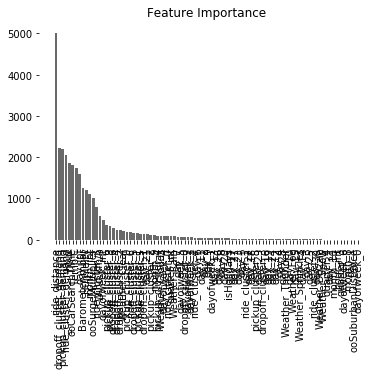

In [86]:
# Sort feature importances in descending order
indices = np.argsort(feature_importances)[::-1]


# Create plot
plt.figure()
plt.title("Feature Importance")

# Add bars
plt.bar(range(len(fNames)), feature_importances[indices], color = 'dimgray')

# Add feature names as x-axis labels
plt.xticks(range(len(fNames)), fNames[indices], rotation=90)
    
for spine in plt.gca().spines.values():
    spine.set_visible(False)
    
plt.show()

In [87]:
feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(fNames, feature_importances):
    feats[feature] = importance #add the name/value pair 

# create DataFrame
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'feature importances'})

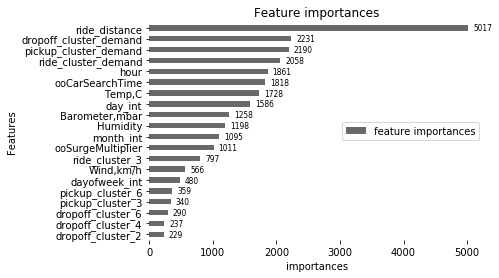

In [88]:
ax = importances.sort_values(by='feature importances').tail(20).plot(kind='barh', color = 'dimgray')

for p in ax.patches:
    ax.annotate(
        str(int(p.get_width())),
        (p.get_x() + p.get_width(), p.get_y()),
        xytext=(5,0),
        textcoords='offset points',
        horizontalalignment='left',
        fontsize=7.5
)
    
for spine in plt.gca().spines.values():
    spine.set_visible(False)
    
plt.title('Feature importances')
plt.xlabel('importances')
plt.ylabel('Features')
plt.legend(loc="center right")
plt.show()